# Enfriamiento Simulado

Se ha de implementar el algoritmo de Enfriamiento Simulado (ES) con las siguientes 
componentes:  
* Esquema de enfriamiento: Se implementará el esquema de Cauchy, Tk = T0/(1 + k)
* Condición de enfriamiento L(T): Se enfriará la temperatura, y finalizará a la iteración actual, cuando se haya generado un número máximo de vecinos  (independientemente de si han sido o no aceptados).
* Condición de parada: El algoritmo finalizará cuando se alcance un número máximo de iteraciones (enfriamientos).  

Se calculará la temperatura inicial en función de la siguiente fórmula:  
T0 = (μ / (-log(Φ)) ) * C(Si)  
donde T0 es la temperatura inicial, C(Si) es el costo de la solución inicial y Φ[0,1] es la probabilidad de aceptar una solución un µ por 1 peor que la inicial. En las ejecuciones se considerar Φ=µ= 0,3.  
El número de soluciones generadas en cada temperatura será L(T) = 20 y el número de enfriamientos (iteraciones) será 80 ·n.  
Se debe repetir también 10 veces con distintas semillas, partiendo de una solución inicial aleatoria.

---
## Librerías
- matplotlib: necesaria para la representación de la solución.
- pandas: necesaria para la representación de resultados.
- random: necesaria para el control de números aleatorios.
- datetime: necesaria para la obtención de una semilla inicial que genere las demás semillas.
- multiprocessing: necesaria para la ejecución concurrente de las soluciones.
- itertools: necesaria para combinar las semillas con los dataset en la ejecución concurrente.
- ipynb: necesaria para cargar la función busqueda_aleatorio de otro fichero. Esto permite la ejecución concurrente en Jupyter.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from random import seed
from random import randint
from datetime import datetime
from multiprocessing import Pool, TimeoutError
import itertools
from ipynb.fs.full.algoritmo import *

---
## Funciones auxiliares
- cargar_fichero(nombre_fichero): devuelve un array con las ciudades almacenadas en el fichero. [ [ ciudad, posición x , posición y ] [...] ... ]
- calcular_distancia_euclidea(node_1,node_2): devuelve en la distancia entre las dos ciudades.
- dibujar_flecha(A, B): dibuja una flecha entre el punto A y B apuntando a B. 
- representacion(camino, nombre, distancia): representa las ciudades y el camino calculado.
- representacion_datos(result,nombre): representa la solución obtenida de la ejecución concurrente de un dataset.

In [2]:
def cargar_fichero(nombre_fichero):
    
    fichero = open( "../Dataset/" + nombre_fichero + ".tsp", 'r')
    
    for i in range(3):
        fichero.readline()
        
    numero_de_ciudades = fichero.readline().strip().split()[1]
    
    for i in range(2):
        fichero.readline()
        
    ciudades = []
    for i in range(0, int(numero_de_ciudades)):
        ciudad,x,y = fichero.readline().strip().split()[:]
        ciudades.append([int(ciudad),float(x),float(y)])  
        
    fichero.close()
    
    return ciudades

In [3]:
def calcular_distancia_euclidea(ciudad_1,ciudad_2):
    
    x1,y1 = ciudad_1[1 :]
    x2,y2 = ciudad_2[1 :]
    
    xd = x1 - x2
    yd = y1 - y2
    
    return round(math.sqrt( xd*xd + yd*yd ))

In [4]:
def dibujar_flecha(A, B):
    plt.arrow(A[0], A[1], B[0] - A[0], B[1] - A[1],
              head_width=1.3, length_includes_head=True)

In [5]:
def representacion(camino, nombre, distancia):
    
    plt.figure(figsize=(10,10))
    
    for i in range(len(camino)):
        if(i == 0):
            plt.plot(camino[i][1], camino[i][2] , "o", color="green")
        else:
            plt.plot(camino[i][1], camino[i][2] , "*", color="red")
        
        if(i<len(camino)-1):
            dibujar_flecha([camino[i][1], camino[i][2]],[camino[i+1][1], camino[i+1][2]])
        else:
            dibujar_flecha([camino[i][1], camino[i][2]],[camino[0][1], camino[0][2]])
    
    plt.title(nombre + " : " + str(distancia))

In [6]:
def representacion_datos(result,nombre):
    semilla_coste = pd.DataFrame(columns=["Semilla","Coste","Nº de evaluaciones"])
    for i in range(10):
        semilla_coste.loc[len(semilla_coste)] = [semillas[i],result[i][1], result[i][2]]
    display(semilla_coste)

    print("Media coste: ", semilla_coste[['Coste']].mean()[0])
    print("Desviación típica coste: ", semilla_coste[['Coste']].std()[0])
    print("Media nº de evaluaciones: ", semilla_coste[['Nº de evaluaciones']].mean()[0])
    print("Desviación típica nº de evaluaciones: ", semilla_coste[['Nº de evaluaciones']].std()[0])


    print()
    print("Representación de la mejor solución: ")
    indice = semilla_coste[['Coste']].idxmin()[0]


    representacion(result[indice][0], nombre, result[indice][1])

---
## Función de evaluación
Esta función genera el coste total de la solución pasara por parámetro. Para ello recorre todas las ciudades de la solución sumando el coste entre ellas. 

In [7]:
def funcion_de_evaluacion(solucion):
    coste = 0
    for indice in range(len(solucion)-1):
        coste += calcular_distancia_euclidea(solucion[indice],solucion[indice+1])
    coste += calcular_distancia_euclidea(solucion[-1],solucion[0])
    return coste

---
## Lectura de ficheros y ejecución del algoritmo
Para poder ejecutar correctamente el algoritmo de forma concurrente en Jupyter, este debe ser cargado de forma externa. Para ello se ha usado la librería ipynb.

In [8]:
st70 = cargar_fichero("st70")
ch130 = cargar_fichero("ch130")
a280 = cargar_fichero("a280")
p654 = cargar_fichero("p654")
vm1084 = cargar_fichero("vm1084")
vm1748 = cargar_fichero("vm1748")

### Generación de semillas

In [9]:
semillas = []
dt = datetime.now()
for i in range(10):
    semillas.append(randint(0,dt.microsecond))
print("Semillas generadas:")
print(semillas)

Semillas generadas:
[120936, 186225, 173671, 99527, 43096, 592031, 135732, 350391, 446692, 151151]


#### st70

,Semilla,Coste,Nº de evaluaciones
0,30299.0,1081.0,112001.0
1,70392.0,974.0,112001.0
2,5470.0,949.0,112001.0
3,10859.0,1090.0,112001.0
4,36392.0,919.0,112001.0
5,24928.0,1128.0,112001.0
6,35733.0,1010.0,112001.0
7,48372.0,1025.0,112001.0
8,34513.0,1038.0,112001.0
9,17281.0,1077.0,112001.0


Media coste:  1029.1
Desviación típica coste:  67.0927219103036
Media nº de evaluaciones:  112001.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


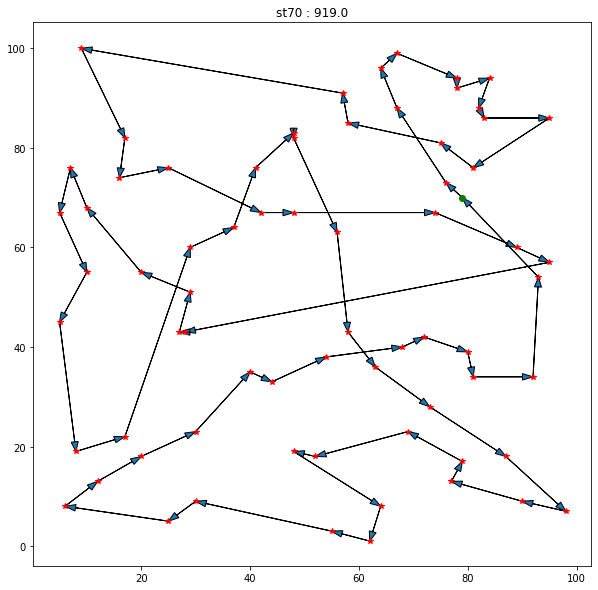

In [12]:
import time
dataset = st70
with Pool(processes=5) as pool:
    result = pool.starmap(enfriamiento_simulado,  itertools.product(semillas,[dataset],[20]) )
representacion_datos(result,"st70")

#### ch130


,Semilla,Coste,Nº de evaluaciones
0,322088.0,11780.0,208001.0
1,339560.0,10959.0,208001.0
2,53334.0,11367.0,208001.0
3,274935.0,10867.0,208001.0
4,308145.0,10665.0,208001.0
5,74088.0,11505.0,208001.0
6,216904.0,11088.0,208001.0
7,186764.0,10442.0,208001.0
8,246278.0,9446.0,208001.0
9,205704.0,9965.0,208001.0


Media coste:  10808.4
Desviación típica coste:  712.4178237211332
Media nº de evaluaciones:  208001.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


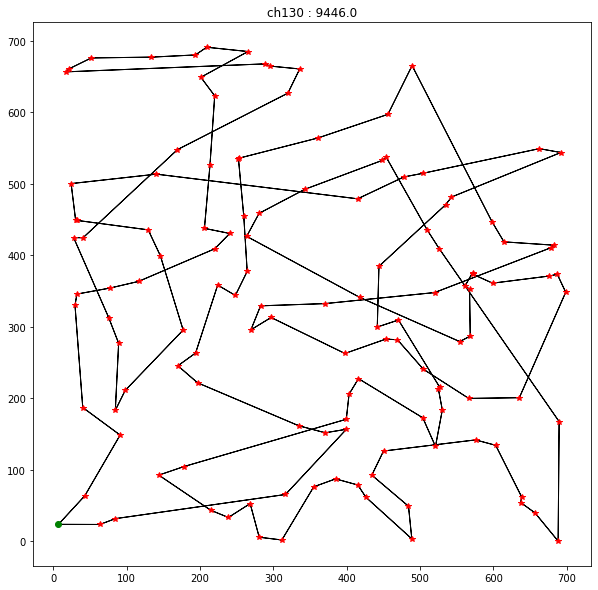

In [11]:
dataset = ch130

with Pool(processes=5) as pool:
    result = pool.starmap(enfriamiento_simulado,  itertools.product(semillas,[dataset],[20]) )
    
representacion_datos(result,"ch130")

#### a280

,Semilla,Coste,Nº de evaluaciones
0,322088.0,6091.0,448001.0
1,339560.0,6824.0,448001.0
2,53334.0,6283.0,448001.0
3,274935.0,6538.0,448001.0
4,308145.0,5790.0,448001.0
5,74088.0,5930.0,448001.0
6,216904.0,6306.0,448001.0
7,186764.0,6233.0,448001.0
8,246278.0,6386.0,448001.0
9,205704.0,5732.0,448001.0


Media coste:  6211.3
Desviación típica coste:  337.9773332307624
Media nº de evaluaciones:  448001.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


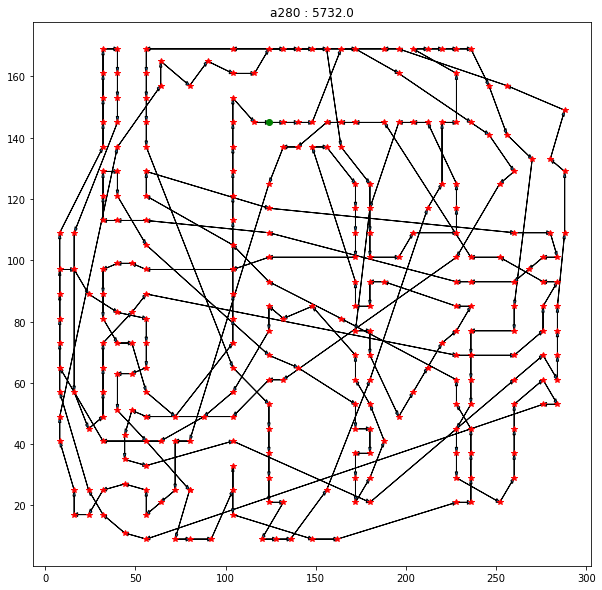

In [12]:
dataset = a280
with Pool(processes=5) as pool:
    result = pool.starmap(enfriamiento_simulado,  itertools.product(semillas,[dataset],[20]) )

representacion_datos(result,"a280")

#### p654

,Semilla,Coste,Nº de evaluaciones
0,322088.0,334201.0,1046401.0
1,339560.0,327778.0,1046401.0
2,53334.0,287391.0,1046401.0
3,274935.0,356196.0,1046401.0
4,308145.0,321808.0,1046401.0
5,74088.0,309669.0,1046401.0
6,216904.0,307980.0,1046401.0
7,186764.0,332132.0,1046401.0
8,246278.0,288224.0,1046401.0
9,205704.0,309885.0,1046401.0


Media coste:  317526.4
Desviación típica coste:  21312.92686089308
Media nº de evaluaciones:  1046401.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


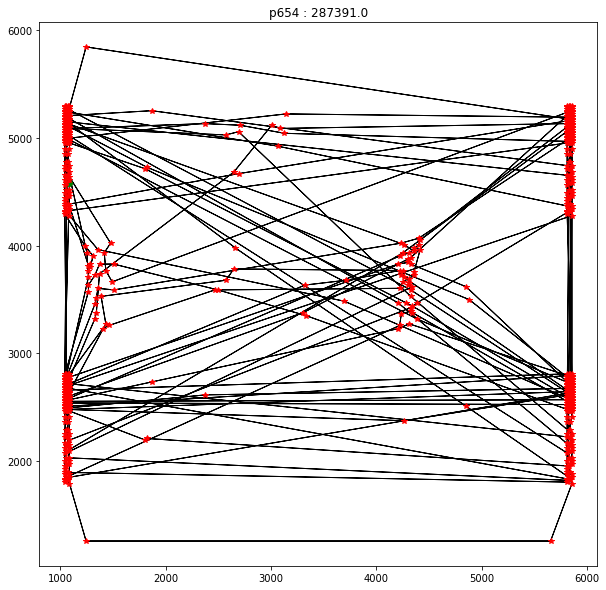

In [13]:
dataset = p654

with Pool(processes=5) as pool:
    result = pool.starmap(enfriamiento_simulado,  itertools.product(semillas,[dataset],[20]) )
    
representacion_datos(result,"p654")

#### vm1084

,Semilla,Coste,Nº de evaluaciones
0,322088.0,1270617.0,1734401.0
1,339560.0,1272234.0,1734401.0
2,53334.0,1342993.0,1734401.0
3,274935.0,1256920.0,1734401.0
4,308145.0,1413170.0,1734401.0
5,74088.0,1285475.0,1734401.0
6,216904.0,1284806.0,1734401.0
7,186764.0,1229869.0,1734401.0
8,246278.0,1234716.0,1734401.0
9,205704.0,1225706.0,1734401.0


Media coste:  1281650.6
Desviación típica coste:  57658.7947463351
Media nº de evaluaciones:  1734401.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


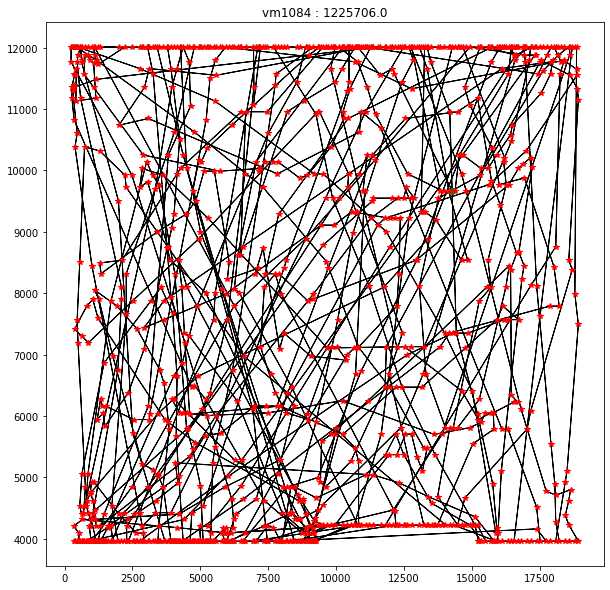

In [14]:
dataset = vm1084

with Pool(processes=5) as pool:
    result = pool.starmap(enfriamiento_simulado,  itertools.product(semillas,[dataset],[20]) )
    
representacion_datos(result,"vm1084")

#### vm1748

,Semilla,Coste,Nº de evaluaciones
0,120936.0,2304465.0,2796801.0
1,186225.0,2342718.0,2796801.0
2,173671.0,2253992.0,2796801.0
3,99527.0,2307193.0,2796801.0
4,43096.0,2219142.0,2796801.0
5,592031.0,2248169.0,2796801.0
6,135732.0,2273591.0,2796801.0
7,350391.0,2293008.0,2796801.0
8,446692.0,2322425.0,2796801.0
9,151151.0,2259583.0,2796801.0


Media coste:  2282428.6
Desviación típica coste:  38053.915941580686
Media nº de evaluaciones:  2796801.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


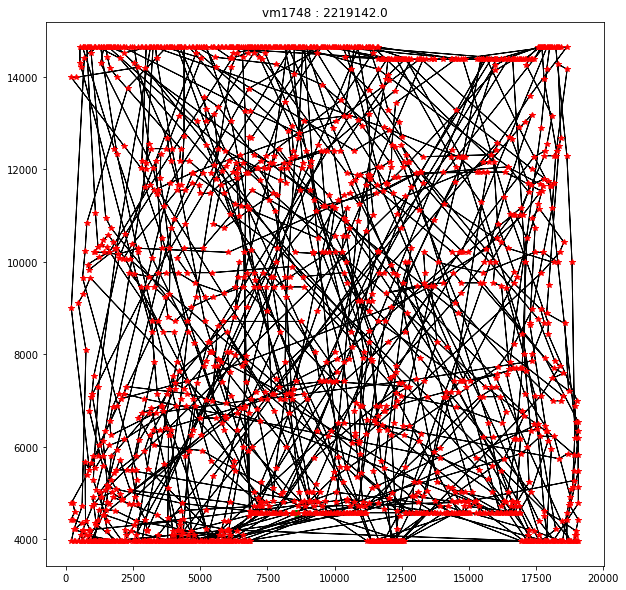

In [11]:
dataset = vm1748
with Pool(processes=5) as pool:
    result = pool.starmap(enfriamiento_simulado,  itertools.product(semillas,[dataset],[20]) )
representacion_datos(result,"vm1748")